# TRABAJO UT11: REDES NEURONALES PROFUNDAS CON KERAS

In [ ]:
# Se monta el drive en el colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Preparamos el entorno
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## REGRESIÓN

In [ ]:
# Importamos el csv
ruta = '/content/drive/MyDrive/CSVs/house_price_madrid.csv'
data = pd.read_csv(ruta,
                      header=0,
                      sep=",",
                      decimal=".",
                      quotechar="\"",
                      encoding='utf-8',
)
data

,price,house_type,house_type_2,rooms,m2,elevator,garage,neighborhood,district
0,495000,planta 1,exterior,3,118.0,True,True,Chopera,Arganzuela
1,485000,planta 2,exterior,2,82.0,True,True,Palos de Moguer,Arganzuela
2,315000,planta 2,exterior,2,72.0,False,False,Legazpi,Arganzuela
3,585000,planta 4,exterior,2,174.0,True,True,Palos de Moguer,Arganzuela
4,255000,bajo,exterior,3,75.0,False,False,Acacias,Arganzuela
...,...,...,...,...,...,...,...,...,...
15970,155000,planta 3,exterior,4,106.0,False,False,Villaverde Alto,villaverde
15971,108000,planta 3,exterior,3,60.0,False,False,San Cristóbal,villaverde
15972,140000,bajo,exterior,2,65.0,False,False,San Cristóbal,villaverde
15973,135000,planta 1,exterior,2,71.0,False,False,Los Rosales,villaverde


In [ ]:
data.dtypes

price             int64
house_type       object
house_type_2     object
rooms             int64
m2              float64
elevator           bool
garage             bool
neighborhood     object
district         object
dtype: object

### ANÁLISIS DE VARIABLES




Variable Objetivo:

* price

Variables Categóricas:

* house_type
* house_type_2
* neighborhood
* district

Variables Numéricas:

* rooms
* m2

Variables Booleanas:

* elevator
* garage

### VALORES MISSING


In [ ]:
data.isnull().sum()

price             0
house_type        0
house_type_2    469
rooms             0
m2                0
elevator          0
garage            0
neighborhood      0
district          0
dtype: int64

In [ ]:
total_count = len(data)
exterior_count = data['house_type_2'].value_counts().get('exterior', 0)
interior_count = data['house_type_2'].value_counts().get('interior', 0)

exterior_percentage = exterior_count / total_count
interior_percentage = interior_count / total_count
total_percentage = exterior_percentage + interior_percentage
exterior_percentage /= total_percentage
interior_percentage /= total_percentage

# Rellenar los valores nulos en house_type_2 basándose en los porcentajes
data.loc[data['house_type_2'].isnull(), 'house_type_2'] = \
    np.random.choice(['exterior', 'interior'],
                     size=data['house_type_2'].isnull().sum(),
                     p=[exterior_percentage, interior_percentage])


print(data['house_type_2'].isnull().sum())


0


### VARIABLE DUMMY


In [ ]:
data = pd.get_dummies(data, columns=['house_type_2'])
data.head()

,price,house_type,rooms,m2,elevator,garage,neighborhood,district,house_type_2_exterior,house_type_2_interior
0,495000,planta 1,3,118.0,True,True,Chopera,Arganzuela,True,False
1,485000,planta 2,2,82.0,True,True,Palos de Moguer,Arganzuela,True,False
2,315000,planta 2,2,72.0,False,False,Legazpi,Arganzuela,True,False
3,585000,planta 4,2,174.0,True,True,Palos de Moguer,Arganzuela,True,False
4,255000,bajo,3,75.0,False,False,Acacias,Arganzuela,True,False


In [ ]:
data = data.drop('house_type_2_interior', axis=1)

In [ ]:
label_encoder = LabelEncoder()


data['district'] = label_encoder.fit_transform(data['district'])
data['neighborhood'] = label_encoder.fit_transform(data['neighborhood'])
data['house_type'] = label_encoder.fit_transform(data['house_type'])

data.head()

,price,house_type,rooms,m2,elevator,garage,neighborhood,district,house_type_2_exterior
0,495000,5,3,118.0,True,True,124,0,True
1,485000,15,2,82.0,True,True,243,0,True
2,315000,15,2,72.0,False,False,219,0,True
3,585000,18,2,174.0,True,True,243,0,True
4,255000,0,3,75.0,False,False,2,0,True


### NORMALIZACIÓN

In [ ]:
# Skewness positiva y kurtosis alta
columns_to_normalize = ['m2', 'rooms', 'price']

features = data.drop(columns='price')

In [ ]:
data[columns_to_normalize] = data[columns_to_normalize].apply(lambda x: x + 1e-10 if x.min() == 0 else x)
data[columns_to_normalize] = np.log(data[columns_to_normalize])

data.head()

,price,house_type,rooms,m2,elevator,garage,neighborhood,district,house_type_2_exterior
0,13.112313,5,1.098612,4.770685,True,True,124,0,True
1,13.091904,15,0.693147,4.406719,True,True,243,0,True
2,12.660328,15,0.693147,4.276666,False,False,219,0,True
3,13.279367,18,0.693147,5.159055,True,True,243,0,True
4,12.449019,0,1.098612,4.317488,False,False,2,0,True


In [ ]:
scaler = MinMaxScaler()
feature = pd.DataFrame(data['m2'])
targets = pd.DataFrame(data['price'])
features = data.drop(columns='price')
features_norm = scaler.fit_transform(features)
feature = scaler.fit_transform(feature)

###ENTRENAMIENTO

In [ ]:
print(features_norm.shape)
n_cols = features_norm.shape[1] # number of predictors
print(n_cols)

(15975, 8)
8


In [ ]:
model = Sequential()
model.add(Dense(70, activation='relu', input_shape=(n_cols,)))
model.add(Dense(70, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 70)                630       
                                                                 
 dense_4 (Dense)             (None, 70)                4970      
                                                                 
 dense_5 (Dense)             (None, 1)                 71        
                                                                 
Total params: 5671 (22.15 KB)
Trainable params: 5671 (22.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(features_norm, targets, validation_split=0.3, epochs=20, verbose=2)

Epoch 1/20
350/350 - 2s - loss: 23.0929 - mse: 23.0929 - val_loss: 1.1230 - val_mse: 1.1230 - 2s/epoch - 5ms/step
Epoch 2/20
350/350 - 1s - loss: 0.2704 - mse: 0.2704 - val_loss: 0.4259 - val_mse: 0.4259 - 1s/epoch - 3ms/step
Epoch 3/20
350/350 - 1s - loss: 0.1922 - mse: 0.1922 - val_loss: 0.4482 - val_mse: 0.4482 - 1s/epoch - 4ms/step
Epoch 4/20
350/350 - 2s - loss: 0.1634 - mse: 0.1634 - val_loss: 0.3934 - val_mse: 0.3934 - 2s/epoch - 5ms/step
Epoch 5/20
350/350 - 2s - loss: 0.1504 - mse: 0.1504 - val_loss: 0.2872 - val_mse: 0.2872 - 2s/epoch - 5ms/step
Epoch 6/20
350/350 - 4s - loss: 0.1427 - mse: 0.1427 - val_loss: 0.3592 - val_mse: 0.3592 - 4s/epoch - 10ms/step
Epoch 7/20
350/350 - 2s - loss: 0.1400 - mse: 0.1400 - val_loss: 0.3866 - val_mse: 0.3866 - 2s/epoch - 5ms/step
Epoch 8/20
350/350 - 1s - loss: 0.1372 - mse: 0.1372 - val_loss: 0.3108 - val_mse: 0.3108 - 1s/epoch - 4ms/step
Epoch 9/20
350/350 - 1s - loss: 0.1354 - mse: 0.1354 - val_loss: 0.3694 - val_mse: 0.3694 - 1s/epoch 

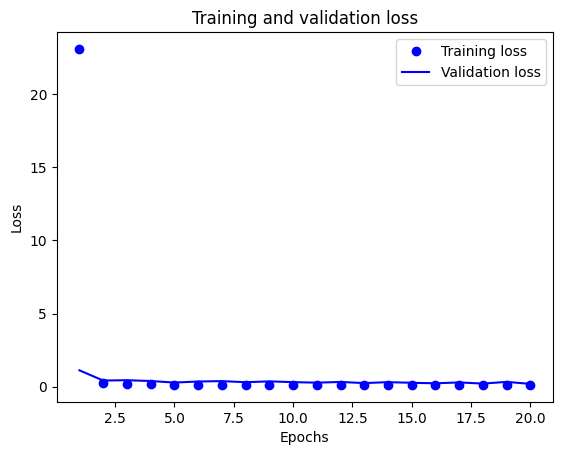

In [ ]:

history_dict = history.history
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)
epochs = range(1, 21)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

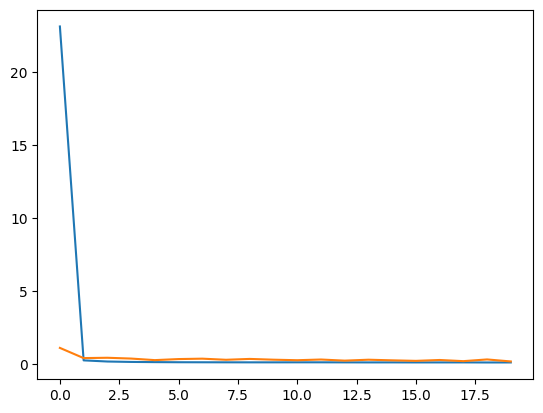

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets, test_size = 0.3,
                                                    random_state = 42)

model.evaluate(X_test,y_test)

150/150 [==============================] - 0s 2ms/step - loss: 0.1466 - mse: 0.1466


[0.14656420052051544, 0.14656420052051544]

###COMPARATIVAS

Regresión Lineal simple:
Mean squared error: 0.32


Regresión Lineal múltiple:
Mean squared error: 0.20

Regresión Lineal Polinomial:
Mean squared error: 0.11

SVR:
Mean squared error: 0.13

DecisionTreeRegressor:
Mean squared error: 0.09

DecisionTreeRegressor:
Mean squared error: 0.05

Red neuronal:
Mean squared error: 0.14

Comparando los modelos con otros hecho previamente sobre el mismo dataset con la métrica de mse, podemos ver que el modelo se encontraría en eficacia entre el SVR y el modelo de regresión lineal polinomial

###PREDICCIONES

In [ ]:
df = pd.DataFrame(features_norm)
df2 = pd.DataFrame(targets)

In [ ]:
concrete_sample = 1
concrete_data = df.iloc[concrete_sample,:]
print(concrete_data)
print(concrete_data.shape)
# and it's real strength
print(targets.iloc[1])

0    0.600000
1    0.186652
2    0.638961
3    1.000000
4    1.000000
5    0.714706
6    0.000000
7    1.000000
Name: 1, dtype: float64
(8,)
price    13.091904
Name: 1, dtype: float64


In [ ]:
concrete_data_array = np.array(concrete_data)
print(concrete_data_array)
print(concrete_data_array.shape)
concrete_sam = concrete_data_array.reshape(1,8)
print(concrete_sam)
print(concrete_sam.shape)

[0.6        0.18665241 0.63896108 1.         1.         0.71470588
 0.         1.        ]
(8,)
[[0.6        0.18665241 0.63896108 1.         1.         0.71470588
  0.         1.        ]]
(1, 8)


In [ ]:
predicted_strength = model.predict(concrete_sam[0:1,:])
print(predicted_strength)

1/1 [==============================] - 0s 166ms/step
[[13.060924]]


Valor real = 13.091904

valor predicho = 13.060924

Como se puede observar al comparar los resultados, ambos tienen valores muy parecidos. Por lo que se podría decir que lo ha predicho correctamente.

In [ ]:
predicted_strength = model.predict(features_norm)
print(predicted_strength)

500/500 [==============================] - 2s 4ms/step
[[13.297361]
 [13.060925]
 [12.493786]
 ...
 [12.516692]
 [12.273718]
 [12.212435]]


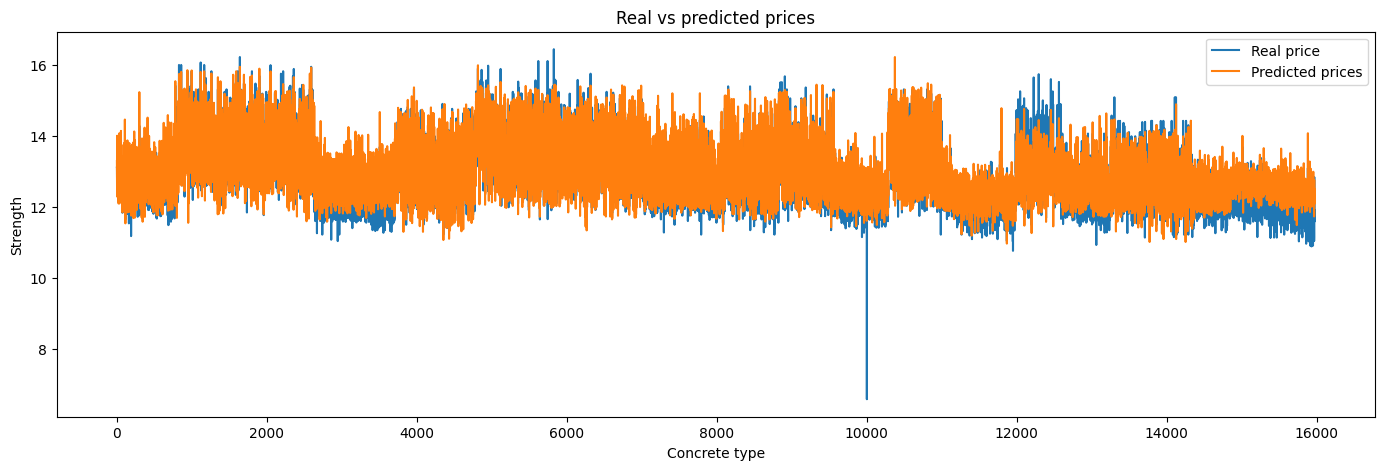

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(targets, label='Real price')
plt.plot(predicted_strength, label='Predicted prices')
plt.title('Real vs predicted prices')
plt.xlabel('Concrete type')
plt.ylabel('Strength')
plt.legend()
plt.show()

En este gráfico se pueden ver los valores de los precios predichos con los reales. Según la gráfica, los valores de los precios reales con los predichos son muy parecidos. Las predicciones van bien en casi todo el gráfico pero vemos que difieren un poco más los resultados sobre los 13000 y los últimos mil registros.

##CLASIFICACIÓN

In [ ]:
# Importamos el csv
ruta = '/content/drive/MyDrive/CSVs/Cancer_Data.csv'
data = pd.read_csv(ruta,
                      header=0,
                      sep=",",
                      decimal=".",
                      quotechar="\"",
                      encoding='utf-8',
)
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [ ]:
data.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

###ANÁLISIS DE VARIABLES

Variable Objetivo:
* diagnosis

Variables numéricas:
* radius_mean
* texture_mean
* perimeter_mean
* area_mean
* smoothness_mean
* compactness_mean
* concavity_mean
* concave points_mean
* symmetry_mean
* fractal_dimension_mean
* radius_se
* texture_se
* perimeter_se
* area_se
* smoothness_se
* compactness_se
* concavity_se
* concave points_se
* symmetry_se
* fractal_dimension_se
* radius_worst
* texture_worst
* perimeter_worst
* area_worst
* smoothness_worst
* compactness_worst
* concavity_worst
* concave points_worst
* symmetry_worst
* fractal_dimension_worst



###VARIABLES MISSING

In [ ]:
data.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

###VARIABLES DUMMY

In [ ]:
data = pd.get_dummies(data, columns=['diagnosis'])
data.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,diagnosis_B,diagnosis_M
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,False,True
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,False,True
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,False,True
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,False,True
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,False,True


In [ ]:
data = data.drop('Unnamed: 32', axis=1)
data = data.drop('diagnosis_B', axis=1)
data = data.drop('id', axis=1)

###NORMALIZACIÓN

In [ ]:
columns_to_normalize = ['area_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'symmetry_se','fractal_dimension_se','area_worst', 'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst', 'concavity_se']


In [ ]:
data[columns_to_normalize] = data[columns_to_normalize].apply(lambda x: x + 1e-10 if x.min() == 0 else x)
data[columns_to_normalize] = np.log(data[columns_to_normalize])

data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_M
0,17.99,10.38,122.80,6.908755,0.11840,0.27760,0.3001,0.14710,0.2419,-2.541985,...,17.33,184.60,7.610358,0.1622,-0.407066,0.7119,0.2654,-0.776311,-2.129472,True
1,20.57,17.77,132.90,7.189922,0.08474,0.07864,0.0869,0.07017,0.1812,-2.870510,...,23.41,158.80,7.578657,0.1238,-1.678788,0.2416,0.1860,-1.290984,-2.418894,True
2,19.69,21.25,130.00,7.092574,0.10960,0.15990,0.1974,0.12790,0.2069,-2.813577,...,25.53,152.50,7.443664,0.1444,-0.856843,0.4504,0.2430,-1.018047,-2.435203,True
3,11.42,20.38,77.58,5.956096,0.14250,0.28390,0.2414,0.10520,0.2597,-2.328518,...,26.50,98.87,6.341593,0.2098,-0.143524,0.6869,0.2575,-0.409774,-1.754464,True
4,20.29,14.34,135.10,7.167809,0.10030,0.13280,0.1980,0.10430,0.1809,-2.833103,...,16.67,152.20,7.362011,0.1374,-1.584745,0.4000,0.1625,-1.442230,-2.566811,True


In [ ]:
sc_X = StandardScaler()
X = data.drop(columns='diagnosis_M')
y= pd.DataFrame(data['diagnosis_M'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

In [ ]:
n_columns = X.shape[1]
n_columns

30

###ENTRENAMIENTO

In [ ]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_columns,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_sc, y_train, validation_split=0.2, epochs=20, verbose=2)

Epoch 1/20
11/11 - 1s - loss: 0.6534 - accuracy: 0.5206 - val_loss: 0.5179 - val_accuracy: 0.8488 - 1s/epoch - 118ms/step
Epoch 2/20
11/11 - 0s - loss: 0.4507 - accuracy: 0.9471 - val_loss: 0.3565 - val_accuracy: 0.9302 - 57ms/epoch - 5ms/step
Epoch 3/20
11/11 - 0s - loss: 0.2911 - accuracy: 0.9529 - val_loss: 0.2309 - val_accuracy: 0.9535 - 58ms/epoch - 5ms/step
Epoch 4/20
11/11 - 0s - loss: 0.1765 - accuracy: 0.9500 - val_loss: 0.1510 - val_accuracy: 0.9535 - 55ms/epoch - 5ms/step
Epoch 5/20
11/11 - 0s - loss: 0.1220 - accuracy: 0.9588 - val_loss: 0.1115 - val_accuracy: 0.9651 - 56ms/epoch - 5ms/step
Epoch 6/20
11/11 - 0s - loss: 0.0944 - accuracy: 0.9794 - val_loss: 0.0941 - val_accuracy: 0.9767 - 75ms/epoch - 7ms/step
Epoch 7/20
11/11 - 0s - loss: 0.0803 - accuracy: 0.9853 - val_loss: 0.0840 - val_accuracy: 0.9767 - 58ms/epoch - 5ms/step
Epoch 8/20
11/11 - 0s - loss: 0.0710 - accuracy: 0.9853 - val_loss: 0.0816 - val_accuracy: 0.9767 - 71ms/epoch - 6ms/step
Epoch 9/20
11/11 - 0s - 

In [ ]:
# evaluate the model
scores = model.evaluate(X_test_sc, y_test, verbose=0)
print(model.metrics_names) # from the .evaluate method doc we know .metric_names
# stores the labels for the metrics used
print(scores)
print(f"Accuracy: {scores[1]*100}% \nError: {100 - scores[1]*100}%")

['loss', 'accuracy']
[0.09630049765110016, 0.9440559148788452]
Accuracy: 94.40559148788452% 
Error: 5.5944085121154785%


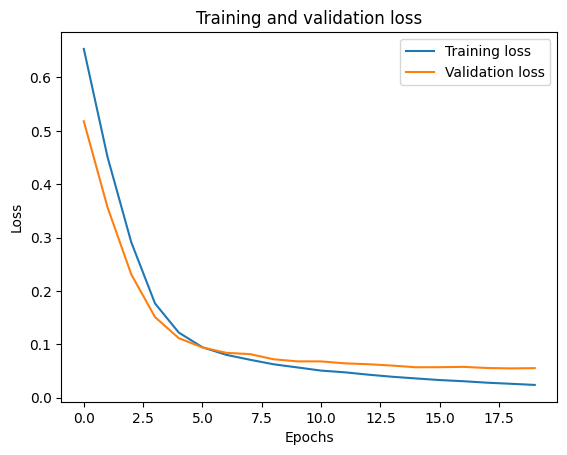

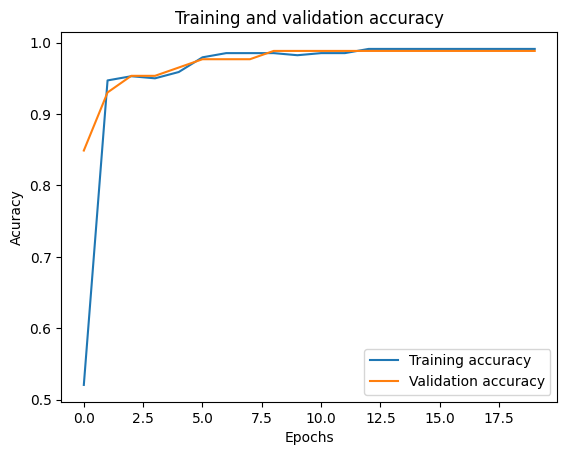

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend()
plt.show()

ACCURACY

   ACC (Logistic Regression): 0.96

   ACC (K_Nearest_Neighbors): 0.96

   ACC (Support Vector Machine SVC): 0.97

   ACC (Naive Bayes): 0.92

   ACC (Classification Decision Tree): 0.96

   ACC (Classification Random Forests): 0.99

   ACC (Redes Neuronales): 0.94

Como podemos observar, hemos obtenido un buen modelo de clasificación, con más de un 94% de precisión. Pero si lo comparamos con resultados de otros 6 modelos, sería el segundo peor.

###PREDICCIONES

In [ ]:
print(y_test[0:10])

     diagnosis_M
512         True
457        False
439        False
298        False
37         False
515        False
382        False
310        False
538        False
345        False


In [ ]:
prediction = model.predict(X_test_sc[0:10]) # X_test_flatten[7]
print(prediction)

1/1 [==============================] - 0s 75ms/step
[[9.9997932e-01]
 [2.4735000e-02]
 [6.6288823e-04]
 [3.3303063e-02]
 [1.1715181e-04]
 [6.4688048e-04]
 [4.8728357e-06]
 [2.2220865e-04]
 [6.9419019e-07]
 [1.0408878e-06]]


Si hacemos predicciones de los 10 primeros valores de test, nos dan valores correctos